### Roman Imaging WCS

#### Generalized World Coordinate System (GWCS) Overview

Roman and JWST use the [GWCS](https://gwcs.readthedocs.io/en/latest/) for managing the World Coordinate System WCS). We call "WCS" the mapping from "pixel" coordinates to some "real-world" physical coordinates - celestial, spectral, time, etc. GWCS is a generalized implementation of WCS aiming to avoid the limitations of the FITS WCS standard. It is a flexible toolkit for expressing and evaluating transformations between pixel and world coordinates, as well as intermediate coordinates. The GWCS object supports a data model which includes the entire transformation pipeline from input pixel coordinates to world coordinates (and vice versa). 

GWCS is based on astropy and supports the [Shared Interface for WCS](https://github.com/astropy/astropy-APEs/blob/main/APE14.rst). The WCS "pipeline" is a list of steps, where each step is a tuple of coordinate frame and a transform to the next frame. The transform in the last step is `None` representing the final coordinate frame of the WCS pipeline.

Transforms are based on [astropy.modeling](https://docs.astropy.org/en/stable/modeling/) and include support for [coordinate units](https://docs.astropy.org/en/stable/units/index.html). Coordinate frames utilize [astropy.coordinates](https://docs.astropy.org/en/stable/coordinates/index.html). 
The GWCS object is serialized to [ASDF](https://asdf-standard.readthedocs.io/en/latest/) using the ASDF [WCS](https://asdf-wcs-schemas.readthedocs.io/en/latest/) and [transforms](https://asdf-transform-schemas.readthedocs.io/en/latest/) extensions.

Download a Roman Level2 simulated file. The downloaded file is called `r002_assign_wcs.asdf`.

#### Roman Imaging WCS

The `assign_wcs` step in the Roman calibration pipeline constructs a WCS object and assigns it to the Level 2 image. The distortion transformations are stored in a reference file in CRDS, with `reftype=distortion`. The distortion includes all transformsations from a detector to a coordinate frame associated with the telescope `(V2, V3)`. The telescope telemetry is used to transform from `(V2, V3)` to celestial coordinates.



We can use `asdf` or `roman_datamodels` to open the file and retrieve the WCS object.

In [1]:
from roman_datamodels import datamodels as rdm

In [2]:
image = rdm.open('../data/r0000101001001001001_0001_wfi01_f158_cal.asdf')
image.search('wcs')

root (AsdfObject)
└─roman (WfiImage) # Level 2 (L2) Calibrated Roman Wide Field Instrument (WFI) Rate Image.
  └─meta (AsdfDictNode)
    ├─cal_step (L2CalStep) # Level 2 Calibration Status
    │ └─assign_wcs (str): COMPLETE # Assign World Coordinate System (WCS) Step
    ├─wcs (WCS) # WCS object
    ├─wcs_fit_results (AsdfDictNode): {'<rot>': 6.992476077717588e-05, '<scale>': 0.9999999999999999, 'cente (truncated)
    └─wcsinfo (Wcsinfo): {'aperture_name': 'WFI01_FULL', 'v2_ref': 1312.9491452484797, 'v3_ref': -1040.78537 (truncated)

The above `search` commands finds the string `wcs` in three places. Using `info` shows that `wcsinfo` is a dictionary holding the pointing `(ra_ref, dec_ref)`, the reference point of the aperture in the telescope `(V2, V3)` system and other WCS related parameters.

In [3]:
image.info(max_rows=600, max_cols=600,show_values=True)

root (AsdfObject)
├─asdf_library (Software)
│ ├─author (str): The ASDF Developers
│ ├─homepage (str): http://github.com/asdf-format/asdf
│ ├─name (str): asdf
│ └─version (str): 4.1.0
├─history (AsdfDictNode)
│ └─extensions (AsdfListNode)
│   ├─0 (ExtensionMetadata)
│   │ ├─extension_class (str): asdf.extension._manifest.ManifestExtension
│   │ ├─extension_uri (str): asdf://asdf-format.org/core/extensions/core-1.6.0
│   │ ├─manifest_software (Software)
│   │ │ ├─name (str): asdf_standard
│   │ │ └─version (str): 1.2.0
│   │ └─software (Software)
│   │   ├─name (str): asdf
│   │   └─version (str): 4.1.0
│   ├─1 (ExtensionMetadata)
│   │ ├─extension_class (str): asdf.extension._manifest.ManifestExtension
│   │ ├─extension_uri (str): asdf://astropy.org/astropy/extensions/units-1.0.0
│   │ └─software (Software)
│   │   ├─name (str): asdf-astropy
│   │   └─version (str): 0.7.1
│   ├─2 (ExtensionMetadata)
│   │ ├─extension_class (str): asdf.extension._manifest.ManifestExtension
│   │ ├─extens

The `WCS` object is in the `image.meta.wcs` attribute.

In [4]:
w = image.meta.wcs

`print` shows the WCS pipeline

In [5]:
print(w)

   From                   Transform                
---------- ----------------------------------------
  detector                            CompoundModel
      v2v3                           DVA_Correction
v2v3vacorr JWST tangent-plane linear correction. v1
  v2v3corr                                 v23tosky
     world                                     None


`repr` prints all transforms. Notable below is the `Expression` section which shows how the transforms are combined. The "join" operator `&` combines two models which take independent inputs and concatenates the outputs. The "conposition" operator, `|`, combines models in series, i.e. chains the output of the first one as input to the second. More information on combining models is available at [Compound Models](https://docs.astropy.org/en/stable/modeling/compound-models.html#).

In [6]:
w

<WCS(output_frame=world, input_frame=detector, forward_transform=Model: CompoundModel
Inputs: ('x0', 'x1')
Outputs: ('lon', 'lat')
Model set size: 1
Expression: [0] & [1] | [2] & [3] | [4] | [5] & [6] | [7] | [8] & [9] | [10] & [11] | [12] & [13] | [14] & [15] | [16] & [17] | [18] | [19] | [20] / [21] | [22] | [23] | [24] | [25] & [26] | [27] | [28] | [29] & [30] | [31] & [32] | [33] | [34] | [35]
Components: 
    [0]: <Shift(offset=1.)>

    [1]: <Shift(offset=1.)>

    [2]: <Shift(offset=-2044.5)>

    [3]: <Shift(offset=-2044.5)>

    [4]: <Mapping((0, 1, 0, 1))>

    [5]: <Polynomial2D(5, c0_0=0., c1_0=0.11034133, c2_0=-0.00000003, c3_0=-0., c4_0=0., c5_0=-0., c0_1=0.00034168, c0_2=-0.00000001, c0_3=-0., c0_4=-0., c0_5=0., c1_1=0.00000014, c1_2=-0., c1_3=0., c1_4=0., c2_1=0., c2_2=-0., c2_3=-0., c3_1=0., c3_2=-0., c4_1=-0.)>

    [6]: <Polynomial2D(5, c0_0=0., c1_0=0.00031436, c2_0=0.00000007, c3_0=0., c4_0=0., c5_0=-0., c0_1=0.10828278, c0_2=0.00000021, c0_3=-0., c0_4=0., c0_5=0.,

In [7]:
from matplotlib import pyplot as plt
#%matplotlib notebook
#%maptlotlib ipympl
from astropy import units as u

2025-06-02 22:14:33,964 - stpipe - WARNING - AstropyDeprecationWarning: Setting CoordinateHelper.coord_wrap directly is deprecated, use CoordinateHelper.set_coord_type instead


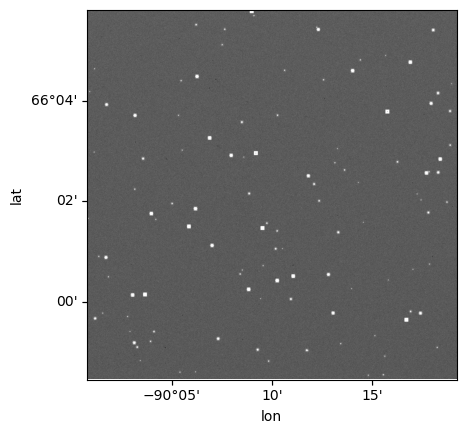

In [8]:
ax = plt.subplot(projection=image.meta.wcs)
plt.imshow(image.data, vmin=.1, vmax=.4, origin='lower')
plt.gray()
plt.grid(color='white', ls='solid')
ax.coords[0].set_format_unit(u.degree)
ax.coords[0].coord_wrap = 180 * u.deg

The WCS can be evaluated directly as a function or using the Shared WCS Interface methods

In [9]:
from gwcs.wcstools import grid_from_bounding_box

The `bounding_box` of a WCS object represents the range of input values over which the transforms are valid. Typically it is the full detector. By default, input values outside the `bounding box` return `NaN`s. 

In [10]:
w.bounding_box

ModelBoundingBox(
    intervals={
        x0: Interval(lower=-0.5, upper=4087.5)
        x1: Interval(lower=-0.5, upper=4087.5)
    }
    model=CompoundModel(inputs=('x0', 'x1'))
    order='F'
)

In [11]:
x, y = grid_from_bounding_box(w.bounding_box)

Evaluating the WCS object returns the numerical values of the result.

In [12]:
ra, dec = w(x, y)
print (ra, dec)

[[269.98690818 269.98683308 269.98675797 ... 269.68030099 269.68022606
  269.68015113]
 [269.98690811 269.98683301 269.9867579  ... 269.68030011 269.68022518
  269.68015025]
 [269.98690804 269.98683294 269.98675783 ... 269.68029923 269.6802243
  269.68014937]
 ...
 [269.98670246 269.98662658 269.9865507  ... 269.6769741  269.67689842
  269.67682274]
 [269.98670242 269.98662654 269.98655065 ... 269.67697332 269.67689764
  269.67682196]
 [269.98670238 269.98662649 269.98655061 ... 269.67697255 269.67689687
  269.67682119]] [[65.97427979 65.97427979 65.97427978 ... 65.9743568  65.97435685
  65.97435689]
 [65.97430963 65.97430963 65.97430963 ... 65.97438661 65.97438666
  65.9743867 ]
 [65.97433947 65.97433947 65.97433947 ... 65.97441642 65.97441647
  65.97441651]
 ...
 [66.09715258 66.09715258 66.09715258 ... 66.09711992 66.09711989
  66.09711987]
 [66.0971829  66.0971829  66.0971829  ... 66.09715021 66.09715018
  66.09715016]
 [66.09721321 66.09721321 66.09721321 ... 66.09718049 66.097180

Using the Shared WCS interface methods returns a Python object of type astropy.coordinates.SkyCoord.

In [13]:
sky = w.pixel_to_world(x, y)

In [14]:
print(sky)

<SkyCoord (ICRS): (ra, dec) in deg
    [[(269.98690818, 65.97427979), (269.98683308, 65.97427979),
      (269.98675797, 65.97427978), ..., (269.68030099, 65.9743568 ),
      (269.68022606, 65.97435685), (269.68015113, 65.97435689)],
     [(269.98690811, 65.97430963), (269.98683301, 65.97430963),
      (269.9867579 , 65.97430963), ..., (269.68030011, 65.97438661),
      (269.68022518, 65.97438666), (269.68015025, 65.9743867 )],
     [(269.98690804, 65.97433947), (269.98683294, 65.97433947),
      (269.98675783, 65.97433947), ..., (269.68029923, 65.97441642),
      (269.6802243 , 65.97441647), (269.68014937, 65.97441651)],
     ...,
     [(269.98670246, 66.09715258), (269.98662658, 66.09715258),
      (269.9865507 , 66.09715258), ..., (269.6769741 , 66.09711992),
      (269.67689842, 66.09711989), (269.67682274, 66.09711987)],
     [(269.98670242, 66.0971829 ), (269.98662654, 66.0971829 ),
      (269.98655065, 66.0971829 ), ..., (269.67697332, 66.09715021),
      (269.67689764, 66.097150

Other useful methods include

`getting a transform between intermediate frames`

In [15]:
detector_to_v2v3 = w.get_transform('detector', 'v2v3')
print(detector_to_v2v3)

Model: CompoundModel
Inputs: ('x0', 'x1')
Outputs: ('y0', 'y1')
Model set size: 1
Expression: [0] & [1] | [2] & [3] | [4] | [5] & [6] | [7] | [8] & [9] | [10] & [11]
Components: 
    [0]: <Shift(offset=1.)>

    [1]: <Shift(offset=1.)>

    [2]: <Shift(offset=-2044.5)>

    [3]: <Shift(offset=-2044.5)>

    [4]: <Mapping((0, 1, 0, 1))>

    [5]: <Polynomial2D(5, c0_0=0., c1_0=0.11034133, c2_0=-0.00000003, c3_0=-0., c4_0=0., c5_0=-0., c0_1=0.00034168, c0_2=-0.00000001, c0_3=-0., c0_4=-0., c0_5=0., c1_1=0.00000014, c1_2=-0., c1_3=0., c1_4=0., c2_1=0., c2_2=-0., c2_3=-0., c3_1=0., c3_2=-0., c4_1=-0.)>

    [6]: <Polynomial2D(5, c0_0=0., c1_0=0.00031436, c2_0=0.00000007, c3_0=0., c4_0=0., c5_0=-0., c0_1=0.10828278, c0_2=0.00000021, c0_3=-0., c0_4=0., c0_5=0., c1_1=-0.00000002, c1_2=-0., c1_3=-0., c1_4=0., c2_1=-0., c2_2=-0., c2_3=0., c3_1=-0., c3_2=-0., c4_1=-0.)>

    [7]: <Mapping((0, 1, 0, 1))>

    [8]: <Polynomial2D(1, c0_0=0., c1_0=-0.5, c0_1=-0.8660254)>

    [9]: <Polynomial2D(1, c

`showing the coorindate frames in the WCS pipeline`

In [16]:
print(w.available_frames)

['detector', 'v2v3', 'v2v3vacorr', 'v2v3corr', 'world']


Retrieving the entire `forward` or `backward` transform

In [17]:
print(w.forward_transform)

Model: CompoundModel
Inputs: ('x0', 'x1')
Outputs: ('lon', 'lat')
Model set size: 1
Expression: [0] & [1] | [2] & [3] | [4] | [5] & [6] | [7] | [8] & [9] | [10] & [11] | [12] & [13] | [14] & [15] | [16] & [17] | [18] | [19] | [20] / [21] | [22] | [23] | [24] | [25] & [26] | [27] | [28] | [29] & [30] | [31] & [32] | [33] | [34] | [35]
Components: 
    [0]: <Shift(offset=1.)>

    [1]: <Shift(offset=1.)>

    [2]: <Shift(offset=-2044.5)>

    [3]: <Shift(offset=-2044.5)>

    [4]: <Mapping((0, 1, 0, 1))>

    [5]: <Polynomial2D(5, c0_0=0., c1_0=0.11034133, c2_0=-0.00000003, c3_0=-0., c4_0=0., c5_0=-0., c0_1=0.00034168, c0_2=-0.00000001, c0_3=-0., c0_4=-0., c0_5=0., c1_1=0.00000014, c1_2=-0., c1_3=0., c1_4=0., c2_1=0., c2_2=-0., c2_3=-0., c3_1=0., c3_2=-0., c4_1=-0.)>

    [6]: <Polynomial2D(5, c0_0=0., c1_0=0.00031436, c2_0=0.00000007, c3_0=0., c4_0=0., c5_0=-0., c0_1=0.10828278, c0_2=0.00000021, c0_3=-0., c0_4=0., c0_5=0., c1_1=-0.00000002, c1_2=-0., c1_3=-0., c1_4=0., c2_1=-0., c2_2=-0

In [18]:
print(w.backward_transform)

Model: CompoundModel
Inputs: ('lon', 'lat')
Outputs: ('y0', 'y1')
Model set size: 1
Expression: [0] | [1] | [2] | [3] & [4] | [5] & [6] | [7] | [8] | [9] / [10] | [11] | [12] | [13] | [14] & [15] | [16] | [17] | [18] & [19] | [20] & [21] | [22] & [23] | [24] & [25] | [26] | [27] & [28] | [29] | [30] & [31] | [32] & [33] | [34] & [35]
Components: 
    [0]: <SphericalToCartesian()>

    [1]: <RotationSequence3D(angles=[269.83252549, -66.03550955, -59.84667936,  -0.28910705,  -0.3647081 ])>

    [2]: <CartesianToSpherical()>

    [3]: <Scale(factor=3600.)>

    [4]: <Scale(factor=3600.)>

    [5]: <Scale(factor=0.00027778, name='arcsec_to_deg_1D')>

    [6]: <Scale(factor=0.00027778, name='arcsec_to_deg_1D')>

    [7]: <SphericalToCartesian(name='s2c')>

    [8]: <RotationSequence3D(angles=[ 0.3647081 ,  0.28910705, 59.84667936], name='det_to_optic_axis')>

    [9]: <Mapping((0, 1, 2), name='xyz')>

    [10]: <Mapping((0, 0, 0), name='xxx')>

    [11]: <Mapping((1, 2), name='xtyt')>

    

Other GWCS features include the ability to

- insert additional frames and transforms
- compute the inverse of the transforms using an iterative numerical method (in case an inverse transform is not provided)
- create  FITS approximation using the SIP convention to represent the distortion
- convert to other celestial frames usnig the `Shared API`
